<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:10px 5px'> 
Master Thesis Yannik Haller - Sentiment Analysis VADER
</h1>
</div>

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
1. Load required packages
</h2>
</div>

In [1]:
# Import required baseline packages
import re
import os
import glob
import time
import sys
import pandas as pd
import numpy as np
from pprint import pprint

# Change pandas' setting to print out long strings
pd.options.display.max_colwidth = 200

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Set global parameters for plotting
import matplotlib.pylab as pylab
params = {'legend.fontsize': 10,
          'figure.figsize': (8, 6),
          'axes.labelsize': 14,
          'axes.titlesize': 16,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10}
pylab.rcParams.update(params)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy (for lemmatization)
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

# TextBlob (for Sentiment Analysis)
from textblob import Blobber
from textblob_de import PatternTagger, PatternAnalyzer

# Enable logging for gensim (optional)
import logging
logging.basicConfig(format = '%(asctime)s : %(levelname)s : %(message)s', level = logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)

In [2]:
# Set the appropriate working directory
os.chdir('D:\\Dropbox\\MA_data')

In [3]:
# Define a function to read in the preprocessed fulltext data
def read_preprocessed_fulltext(language):
    # Raise an error if an inadmissible language is chosen
    allowed_languages = ['de', 'en', 'fr', 'it']
    if language not in allowed_languages:
        raise ValueError("Invalid language. Expected one of: %s" % allowed_languages)
    
    # Set the appropriate working directory
    os.chdir('D:\\Dropbox\\MA_data')

    # Define the name of the file to load
    filename = "Preprocessed/Sentiment_Analysis/Fulltext/"+language+"_fulltext_senti.csv"

    # Read in the data
    tx_ft = pd.read_csv(filename, index_col = 0, dtype = {'tx': object})

    # Get the articles' index together with an enumeration to identify their position in the list of precleaned articles
    idx = tx_ft.index
    idx = pd.DataFrame(idx, columns = [language+'_idx'])

    # Extract the text data as a list of articles
    tx_ft = tx_ft.tx.to_list()

    # Return the preprocessed data
    return tx_ft, idx

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
2.1 Sentiment Assessment of the Articles
</h2>
</div>

Since the most convenient way to access GerVADER is from the computer's command line (i.e. cmd if you are using Windows as an operating system), we do so in the following by applying the following steps sequentially:

1. Download the German Vader sentiment module from the according Github repository (link: https://github.com/KarstenAMF/GerVADER). 

2. Unzip the file, rename the retrieved folder from "GerVADER" to "GerVADER_original" and save it to some path (referred to as Path\to\GerVADER_original in the following). For me this path is C:\Users\Hallk\Documents\Programming\Additional_stuff\GerVADER_original.

3. Replace the original "vaderSentimentGER.py" file in the downloaded folder with the adjusted "vaderSentimentGER.py" file in the "GerVADER_original" folder provided by this thesis (minor adjustments have been applied to the code). (Note: Alternatively to applying steps 1-3 one could also just copy the entire "GerVADER_original" folder provided by this thesis to Path\to\GerVADER_original and continue with step 4)

4. Copy the tsv file created in the Jupyter notebook "2.1 Data_pp_Sentiment_Vader_V1.1_de" (called "de_fulltext_senti.tsv") into the aforementioned "GerVADER_original" folder on your machine.

5. Open your machine's command window and navigate to the "GerVADER_original" folder by entering the following to the command: cd Path\to\GerVADER_original

6. Next, enter the command: python GERvaderModule.py

7. Choose: 2

8. Enter the name of the tsv file mentioned above

9. Choose N or insert the name you want to give to the output folder

If all these steps are executed the articles' sentiments will be evaluated by the algorithm and 4 distinct output tables in tsv format will be generated. One output file contains the text and sentiment assessment for the entirety of articles, while the remaining three solely contain articles classified as negative, neutral or positive, respectively. All resulting output files are then stored within the folder 'results' located within the "GerVADER_original" folder.

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
2.2 Extract the resulting polarity scores
</h2>
</div>

Before we start, we have to copy the resulting tsv file named "GERVADER\_\_all_docs.tsv" to an easily accessible spot on our machine, such that we can read it in conveniently (for me it is the folder c:\\Users\\Hallk\\Dropbox\\MA_data\\Sentiment\\Vader\\GerVADER). Furthermore, we should rename it to "GERVADER\_\_all_docs_original.tsv" to prevent issues that otherwise would occur later on.



In [4]:
# Read in the resulting tsv file
Vader_tx_pol = pd.read_csv("Sentiment/Vader/GerVADER/GERVADER__all_docs_original.tsv", sep = '\t', header = None, usecols = [0,2], names = ['tx','Vader_polarity'])

In [5]:
## Assign the correct article indexes to the dataframe
# Get the indexes
de_idx = read_preprocessed_fulltext('de')[1]
# Assign the indexes accordingly
Vader_tx_pol.index = de_idx.de_idx.values.tolist()

In [6]:
# Take a look at the created dataframe
Vader_tx_pol

,tx,Vader_polarity
16553,"Rückkehrer Stefan Meier überragt beim 7:6 gegen die Flames. Herisau bangt allerdings am Schluss. Lukas PfiffnerIn der vergangenen Saison tat sich der UHC Herisau darin hervor, immer wieder einen ...",0.9691
16554,Fussball Auch im neunten Promotion League Spiel hintereinander blieben die Brühler unbesiegt. Sie trotzten dem unangefochtenen Ligakrösus Yverdon ein Unentschieden ab. Nicolas Eberle brachte die ...,0.9501
16555,Fussball Das 1. Liga Team des FC St. Gallen spielte zu Hause gegen Paradiso 0:0. Über 90 Minuten gab es keine einzige klare Torchance. Zwar kamen beide Mannschaften dank einigen schönen Spielzüge...,0.6287
16556,"Liebe Klimajugendliche, Ausgabe vom 28. SeptemberMit dieser Montagskolumne der Autorin und Kabarettistin, studierten Erziehungswissenschaftlerin und Preisträgerin des Salzburger Stiers 2019, Patt...",0.5972
16557,Die Regierung will den Ostschweizer Innovationspark mit zehn Millionen Franken unterstützen à fonds perdu. Regula WeikDiesmal soll es klappen. Die Zusage des Bundesrats steht zwar noch aus. Doch ...,0.9982
...,...,...
2441178,Bist du beim Abfalltrennen auch überfordert? Wir kennen die häufigsten Fehler und ihre Lösung. TEXTCLAUDIA HOTTIGER35668 tPET wurden 2019 schweizweit recyceltRichtig RecycelnWenn es ums Abfalltre...,0.9693
2441179,ZÜRICH. Seit fast vier Jahren gilt Daniel als vermisst. Seine Schwester kämpft bis heute mit seinem Verschwinden. Eines Montagmorgens im Mai 2017 verliess Daniel (42) sein Büro und wurde seither ...,-0.7441
2441180,TOKIO. Trotz des Corona Notstands in Japan und der Umfragemehrheiten gegen Olympia im Sommer sieht IOC Chef Thomas Bach keinen Anlass für eine Absage der Spiele. Wir haben zurzeit überhaupt keine...,0.8391
2441181,GUNTEN. Im Zusammenhang mit der toten tätowierten Frau im Thunersee sind bei der Berner Kapo auf die Zeugenaufrufe hin zahlreiche Hinweise aus der Bevölkerung eingegangen. Daraus haben sich Anhal...,-0.8689


In [17]:
# Compare it to the original data (DO NOT RERUN THIS!!!)
de_tx

,tx
16553,"Rückkehrer Stefan Meier überragt beim 7:6 gegen die Flames. Herisau bangt allerdings am Schluss. Lukas PfiffnerIn der vergangenen Saison tat sich der UHC Herisau darin hervor, immer wieder einen ..."
16554,Fussball Auch im neunten Promotion League Spiel hintereinander blieben die Brühler unbesiegt. Sie trotzten dem unangefochtenen Ligakrösus Yverdon ein Unentschieden ab. Nicolas Eberle brachte die ...
16555,Fussball Das 1. Liga Team des FC St. Gallen spielte zu Hause gegen Paradiso 0:0. Über 90 Minuten gab es keine einzige klare Torchance. Zwar kamen beide Mannschaften dank einigen schönen Spielzüge...
16556,"Liebe Klimajugendliche, Ausgabe vom 28. SeptemberMit dieser Montagskolumne der Autorin und Kabarettistin, studierten Erziehungswissenschaftlerin und Preisträgerin des Salzburger Stiers 2019, Patt..."
16557,Die Regierung will den Ostschweizer Innovationspark mit zehn Millionen Franken unterstützen à fonds perdu. Regula WeikDiesmal soll es klappen. Die Zusage des Bundesrats steht zwar noch aus. Doch ...
...,...
2441178,Bist du beim Abfalltrennen auch überfordert? Wir kennen die häufigsten Fehler und ihre Lösung. TEXTCLAUDIA HOTTIGER35668 tPET wurden 2019 schweizweit recyceltRichtig RecycelnWenn es ums Abfalltre...
2441179,ZÜRICH. Seit fast vier Jahren gilt Daniel als vermisst. Seine Schwester kämpft bis heute mit seinem Verschwinden. Eines Montagmorgens im Mai 2017 verliess Daniel (42) sein Büro und wurde seither ...
2441180,TOKIO. Trotz des Corona Notstands in Japan und der Umfragemehrheiten gegen Olympia im Sommer sieht IOC Chef Thomas Bach keinen Anlass für eine Absage der Spiele. Wir haben zurzeit überhaupt keine...
2441181,GUNTEN. Im Zusammenhang mit der toten tätowierten Frau im Thunersee sind bei der Berner Kapo auf die Zeugenaufrufe hin zahlreiche Hinweise aus der Bevölkerung eingegangen. Daraus haben sich Anhal...


In [7]:
# Check for missing values
Vader_tx_pol.isna().sum()

tx                0
Vader_polarity    0
dtype: int64

In [8]:
# Extract the article indices together with the corresponding Vader-polarity scores as a csv file
Vader_tx_pol = Vader_tx_pol[['Vader_polarity']]
# Write the Dataframe to a csv file
Vader_tx_pol.to_csv("Sentiment/Vader/GerVADER/de_vader_polarity_original.csv", index = True, encoding = 'utf-8-sig')

In [9]:
# Read in the data as follows
Vader_tx_pol = pd.read_csv("Sentiment/Vader/GerVADER/de_vader_polarity_original.csv", index_col = 0, dtype = {'Vader_polarity': float})
Vader_tx_pol

,Vader_polarity
16553,0.9691
16554,0.9501
16555,0.6287
16556,0.5972
16557,0.9982
...,...
2441178,0.9693
2441179,-0.7441
2441180,0.8391
2441181,-0.8689


In [10]:
# Take a look at some summary statistics
share_pos = np.round(np.sum(Vader_tx_pol['Vader_polarity'] > 0) / len(Vader_tx_pol),2)
share_neg = np.round(np.sum(Vader_tx_pol['Vader_polarity'] < 0) / len(Vader_tx_pol),2)
print('The share of articles with a positive sentiment is', 100*share_pos,'%')
print('The share of articles with a negative sentiment is', 100*share_neg,'%')
np.round(Vader_tx_pol.describe(), 3)

The share of articles with a positive sentiment is 79.0 %
The share of articles with a negative sentiment is 20.0 %


,Vader_polarity
count,1934313.000
mean,0.551
std,0.670
min,-1.000
25%,0.361
50%,0.936
75%,0.989
max,1.000


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
3. Adjust the undesirable scoring function of the Vader sentiment package
</h2>
</div>

Inspecting the source code of the sentiment algorithm used by the Vader implementation reveals that, on a highly abstracted level, the output polarity score for a document is calculated as follows:

1. Initially assign a valence score of 0 to each token (Note: the valence score refers to a publicly assessed rating of a word's sentiment, ranging from -4 to 4, where -4 means extremely negative and 4 means extremely positive).

2. For each token, check whether it is contained in the underlying sentiment lexicon and, if yes, store the corresponding valence score.

3. Check for any intensifying, attenuating or negating words close to the token and, if required, adjust the valence score according to some specified rules.

4. Sum up the adjusted valence scores obtained for the tokens in a document. For document $j$ this sum is denoted $s_j$ in the following.

5. Obtain a document's polarity score (denoted as $p_j$) on a range from -1 to 1 by normalizing $s_j$ with the following scoring function: $$p_j = \frac{s_j}{\sqrt{s_j^2+15}}$$

However, since (especially for documents with a very clear sentiment) the absolute value of $s_j$ is inherently larger for longer documents, this algorithm delivers more extreme outcomes (in the sense of polarity scores close to -1 or 1) for longer articles. Furthermore, this approach delivers a clearly non-Gaussian distributed polarity score, which is an undesirable property when using it as the dependent variable in a subsequent regression analysis. We claim that this issue can be resolved by taking the average adjusted valence score of all tokens that exhibit a non-zero entry instead, and devide this value by 4 to transform the valence score (ranging from -4 to 4) into a polarity score, ranging from -1 to 1. Formally, this implies the usage of the alternative scoring function
$$p_j =  \frac{1}{4}*\frac{s_j}{l_j},$$
where $l_j$ refers to the number of tokens in document $j$ exhibiting a non-zero valence score. Thus, in order to obtain polarity scores that are calculated by this alternative approach, we propose the follwoing procedure:

1. Copy the the folder "GerVADER_adjusted" provided by this thesis, which contains the adjusted German Vader sentiment module as explained above (scoring function has been adjusted as described above and the same minor adjustments as in the original GerVADER module from the previous section have been applied to the code), and save it to some path (referred to as Path\to\GerVADER_adjusted in the following). For me this path is C:\Users\Hallk\Documents\Programming\Additional_stuff\GerVADER_adjusted.

2. Copy the tsv file created in the Jupyter notebook "2.1 Data_pp_Sentiment_Vader_V1.1_de" (called "de_fulltext_senti.tsv") into the aforementioned "GerVADER_adjusted" folder on your machine.

3. Open your machine's command window and navigate to the "GerVADER_adjusted" folder by entering the following to the command: cd Path\to\GerVADER_adjusted

4. Next, enter the command: python GERvaderModule.py

5. Choose: 2

6. Enter the name of the tsv file mentioned above

7. Choose N or insert the name you want to give to the output folder

If all these steps are executed the articles' sentiments will be evaluated by the adjusted algorithm and the same 4 output tables (in tsv format) as described above will be generated. All resulting output files are then stored within the folder 'results' located within the "GerVADER_adjusted" folder. 

To extract the resulting polarity scores, we now have to copy the resulting tsv file named "GERVADER\_\_all_docs.tsv" to an easily accessible spot on our machine, such that we can read it in conveniently (for me it is the folder c:\\Users\\Hallk\\Dropbox\\MA_data\\Sentiment\\Vader\\GerVADER). Furthermore, we should rename it to "GERVADER\_\_all_docs_adjusted.tsv" to prevent any confusion.

In [4]:
# Read in the resulting tsv file
Vader_tx_pol = pd.read_csv("Sentiment/Vader/GerVADER/GERVADER__all_docs_adjusted.tsv", sep = '\t', header = None, usecols = [0,2], names = ['tx','Vader_polarity'])

In [5]:
## Assign the correct article indexes to the dataframe
# Get the indexes
de_idx = read_preprocessed_fulltext('de')[1]
# Assign the indexes accordingly
Vader_tx_pol.index = de_idx.de_idx.values.tolist()

In [6]:
# Take a look at the created dataframe
Vader_tx_pol

,tx,Vader_polarity
16553,"Rückkehrer Stefan Meier überragt beim 7:6 gegen die Flames. Herisau bangt allerdings am Schluss. Lukas PfiffnerIn der vergangenen Saison tat sich der UHC Herisau darin hervor, immer wieder einen ...",0.1086
16554,Fussball Auch im neunten Promotion League Spiel hintereinander blieben die Brühler unbesiegt. Sie trotzten dem unangefochtenen Ligakrösus Yverdon ein Unentschieden ab. Nicolas Eberle brachte die ...,0.1405
16555,Fussball Das 1. Liga Team des FC St. Gallen spielte zu Hause gegen Paradiso 0:0. Über 90 Minuten gab es keine einzige klare Torchance. Zwar kamen beide Mannschaften dank einigen schönen Spielzüge...,0.2609
16556,"Liebe Klimajugendliche, Ausgabe vom 28. SeptemberMit dieser Montagskolumne der Autorin und Kabarettistin, studierten Erziehungswissenschaftlerin und Preisträgerin des Salzburger Stiers 2019, Patt...",0.3605
16557,Die Regierung will den Ostschweizer Innovationspark mit zehn Millionen Franken unterstützen à fonds perdu. Regula WeikDiesmal soll es klappen. Die Zusage des Bundesrats steht zwar noch aus. Doch ...,0.3197
...,...,...
2441178,Bist du beim Abfalltrennen auch überfordert? Wir kennen die häufigsten Fehler und ihre Lösung. TEXTCLAUDIA HOTTIGER35668 tPET wurden 2019 schweizweit recyceltRichtig RecycelnWenn es ums Abfalltre...,0.1817
2441179,ZÜRICH. Seit fast vier Jahren gilt Daniel als vermisst. Seine Schwester kämpft bis heute mit seinem Verschwinden. Eines Montagmorgens im Mai 2017 verliess Daniel (42) sein Büro und wurde seither ...,-0.0514
2441180,TOKIO. Trotz des Corona Notstands in Japan und der Umfragemehrheiten gegen Olympia im Sommer sieht IOC Chef Thomas Bach keinen Anlass für eine Absage der Spiele. Wir haben zurzeit überhaupt keine...,0.2133
2441181,GUNTEN. Im Zusammenhang mit der toten tätowierten Frau im Thunersee sind bei der Berner Kapo auf die Zeugenaufrufe hin zahlreiche Hinweise aus der Bevölkerung eingegangen. Daraus haben sich Anhal...,-0.5667


In [7]:
# Check for missing values
Vader_tx_pol.isna().sum()

tx                0
Vader_polarity    0
dtype: int64

In [8]:
# Extract the article indices together with the corresponding adjusted Vader-polarity scores as a csv file
Vader_tx_pol = Vader_tx_pol[['Vader_polarity']]
# Write the Dataframe to a csv file
Vader_tx_pol.to_csv("Sentiment/Vader/GerVADER/de_vader_polarity_adjusted.csv", index = True, encoding = 'utf-8-sig')

In [9]:
# Read in the data as follows
Vader_tx_pol = pd.read_csv("Sentiment/Vader/GerVADER/de_vader_polarity_adjusted.csv", index_col = 0, dtype = {'Vader_polarity': float})
Vader_tx_pol

,Vader_polarity
16553,0.1086
16554,0.1405
16555,0.2609
16556,0.3605
16557,0.3197
...,...
2441178,0.1817
2441179,-0.0514
2441180,0.2133
2441181,-0.5667


In [10]:
# Take a look at some summary statistics
share_pos = np.round(np.sum(Vader_tx_pol['Vader_polarity'] > 0) / len(Vader_tx_pol),2)
share_neg = np.round(np.sum(Vader_tx_pol['Vader_polarity'] < 0) / len(Vader_tx_pol),2)
print('The share of articles with a positive sentiment is', 100*share_pos,'%')
print('The share of articles with a negative sentiment is', 100*share_neg,'%')
np.round(Vader_tx_pol.describe(), 3)

The share of articles with a positive sentiment is 79.0 %
The share of articles with a negative sentiment is 20.0 %


,Vader_polarity
count,1934313.000
mean,0.127
std,0.179
min,-1.000
25%,0.029
50%,0.142
75%,0.244
max,1.000


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
4. Extend the underlying sentiment lexicon with common covid-related words
</h2>
</div>

According to the adjusted Vader polarity scores estimated in the previous section most covid related newspaper articles appear to convey a slightly positive sentiment. However, this observation is against our expectations and we therefore try to figure out what might be driving these sentiment classification outcomes to be predominantly positive in the following. Since the Vader sentiment classification package relies on a lexicon based algorithm, inspecting the underlying sentiment lexicon seems a good starting point thereunto. As such, we check whether the following phrases, which - partly intuitively and partly according to the main LDA topic models - are highly indicative for an article to be covid-related, are captured by the used sentiment lexicon:

- 'covid' ($\rightarrow$ 'Covid' in German)
- 'corona' ($\rightarrow$ 'Corona' in German)
- 'coronavirus' ($\rightarrow$ 'Coronavirus' in German)
- 'virus' ($\rightarrow$ 'Virus' in German)
- 'infection' ($\rightarrow$ 'Infektion'/'Ansteckung' in German)
- 'infect' ($\rightarrow$ 'infizieren'/'anstecken' in German)
- 'infected ($\rightarrow$ 'infiziert'/'angesteckt' in German)
- 'infectious' ($\rightarrow$ 'ansteckend' in German)
- 'pandemic' ($\rightarrow$ 'Pandemie' in German)
- 'epidemic' ($\rightarrow$ 'Epidemie' in German)
- 'lockdown' ($\rightarrow$ 'Lockdown' in German)
- 'crisis' ($\rightarrow$ 'Krise' in German)
- 'quarantine' ($\rightarrow$ 'Quarantäne' in German)
- 'hospitalisation' ($\rightarrow$ 'Hospitalisierung' in German)
- 'disease' ($\rightarrow$ 'Krankheit' in German)

Searching these words in the original German Vader lexicon reveals that most of them are not contained, meaning that most words in this list are not assigned an appropriate polarity score and therefore do not influence the overall polarity of the articles in which they appear. Since for all words in the above list it can reasonably be argued that they rather should convey a negative feeling, omitting them results in positively biased polarity scores for articles that contain them. Thus, we chase the following strategy to account for this issue: for each word listed above, we check whether the German equivalent or close synonyms of it are contained in the original German Vader lexicon in a first step. Thus, the following cases may occur:

 - Case 1 - The word itself as well as close synonyms of it are contained: in this case we check whether the valence score assigned to the focal word is negative and, if yes, leave the entry unchanged. Otherwise, we proceed as described in case 3.

 - Case 2 - The word itself is contained, but no close synonyms of it: in this case we check whether the valence score assigned to the focal word is negative and, if yes, leave the entry unchanged. Otherwise, we proceed as described in case 4.

 - Case 3 - A close synonym of the word is contained, but the word itself is not: in this case we check whether the valence score assigned to the synonym is negative and, if yes, assign the same valence score to the focal word. Otherwise, if the synonym's valence score is positive, we proceed as described in case 4.

 - Case 4 - Neither the word itself nor close synonyms of it are contained: in this case we start by checking whether the word's primary word (or a synonym's primary word) is contained in the lexicon and, if yes, assign the same valence score to the focal word. Otherwise, if the primary word is not contained, we continue by checking whether the French (or Italian) equivalent of the word is contained in the French Vader (or Italian sentix) sentiment lexicon. If yes, we assign the focal German word with the same valence score as observed in the French Vader lexicon (or with the valence score that corresponds to the polarity score observed in the Italian sentix lexicon (note: valence score = polarity score * 4)). If this approach also fails, we add the word and its synonyms with all grammatical cases or conjugations to the lexicon and assign a valence score of -4.

According to this strategy, we apply the following editings to the German Vader lexicon:

- 'covid' ($\rightarrow$ 'Covid' in German): not contained $\rightarrow$ assigned with a valence score of -4 (added cases: 'Covid', 'covid')
- 'corona' ($\rightarrow$ 'Corona' in German): not contained $\rightarrow$ assigned with a valence score of -4 (added cases: 'Corona', 'corona')
- 'coronavirus' ($\rightarrow$ 'Coronavirus' in German): not contained $\rightarrow$ assigned with a valence score of -4 (added cases: 'Coronavirus')
- 'virus' ($\rightarrow$ 'Virus' in German): not contained $\rightarrow$ assigned with a valence score of -4 (added cases: 'Virus', 'Viren')
- 'infection' ($\rightarrow$ 'Infektion'/'Ansteckung' in German): 'Infektion' already contained with a valence score of -2.5 $\rightarrow$ left unchanged / 'Ansteckung' not contained $\rightarrow$ assigned with a valence score of -2.5 since it is a close synonym of 'Infektion' (added cases: 'Ansteckung', 'Ansteckungen')
- 'infect' ($\rightarrow$ 'infizieren'/'anstecken' in German): neither 'infizieren' nor 'anstecken' is contained $\rightarrow$ both assigned with a valence score of -2.5 since their primary words are 'Infektion' and 'Ansteckung' (added cases: 'infizieren', 'infiziere', 'infizierst', 'infiziert', 'infizierte', 'infiziertest', 'infizierten', 'infiziertet', 'anstecken', 'stecke', 'steckst', 'steckt', 'stecken', 'steckte', 'stecktest', 'steckte', 'steckten', 'stecktet', 'angesteckt')
- 'infected ($\rightarrow$ 'infiziert'/'angesteckt' in German): neither 'infiziert' nor 'angesteckt' is contained $\rightarrow$ both assigned with a valence score of -2.5 since their primary words are 'Infektion' and 'Ansteckung' (added cases: 'infiziert', 'infizierter', 'infizierte', 'infiziertes', 'infizierten', 'angesteckt', 'angesteckter', 'angesteckte', 'angestecktes', 'angesteckten')
- 'infectious' ($\rightarrow$ 'infektiös'/'ansteckend' in German): neither 'infektiös' nor 'ansteckend' is contained $\rightarrow$ both assigned with a valence score of -2.5 since their primary words are 'Infektion' and 'Ansteckung' (added cases: 'infektiös', 'infektiöser', 'infektiöse', 'infektiöses', 'infektiösen', 'ansteckend', 'ansteckender', 'ansteckende', 'ansteckendes', 'ansteckenden')
- 'pandemic' ($\rightarrow$ 'Pandemie' in German): not contained $\rightarrow$ assigned with a valence score of -2.7 since it is a close synonym of 'Epidemie' (added cases: 'Pandemie', 'Pandemien')
- 'epidemic' ($\rightarrow$ 'Epidemie' in German): already contained with a valence score of -2.7 $\rightarrow$ left unchanged
- 'lockdown' ($\rightarrow$ 'Lockdown'/'Ausgangssperre' in German): 'Lockdown' not contained $\rightarrow$ assigned with a valence score of -4 (added cases: 'Lockdown', 'Lockdowns') / 'Ausgangssperre' not contained $\rightarrow$ assigned with a valence score of -4 (added cases: 'Ausgangssperre', 'Ausgangssperren')
- 'crisis' ($\rightarrow$ 'Krise' in German): already contained with a valence score of -2.4 $\rightarrow$ left unchanged
- 'quarantine' ($\rightarrow$ 'Quarantäne' in German): not contained $\rightarrow$ assigned with a valence score of -4 (added cases: 'Quarantäne', 'Quarantänen')
- 'hospitalisation' ($\rightarrow$ 'Hospitalisierung' in German): not contained $\rightarrow$ assigned with a valence score of -4 (added cases: 'Hospitalisierung', 'Hospitalisierungen')
- 'disease' ($\rightarrow$ 'Krankheit' in German): already contained with a valence score of -2.4 $\rightarrow$ left unchanged

After adjusting the sentiment lexicon as desired we use it to rerun the sentiment analysis. Thus, we have to apply the following steps:

1. Navigate to the folder "GerVADER_adjusted" (located at Path\to\GerVADER_adjusted as described in the previous section) in which the previously created adjusted GerVADER module is located. For me this means to navigate to C:\Users\Hallk\Documents\Programming\Additional_stuff\GerVADER_adjusted.

2. Replace the original lexicon file "GERVaderLexicon.txt" in your "GerVADER_adjusted" folder with the extended "GERVaderLexicon.txt" file located in the subfolder "sentiment_lexicon\extended" within the "GerVADER_adjusted" folder provided by this thesis.

3. Open your machine's command window and navigate to the "GerVADER_adjusted" folder by entering the following to the command: cd Path\to\GerVADER_adjusted

4. Next, enter the command: python GERvaderModule.py

5. Choose: 2

6. Enter the name of the tsv file "de_fulltext_senti.tsv"

7. Choose N or insert the name you want to give to the output folder

If all these steps are executed the articles' sentiments will be evaluated by the adjusted algorithm using the extended sentiment lexicon and the same 4 output tables (in tsv format) as described above will be generated. All resulting output files are then stored within the folder 'results' located within the "GerVADER_adjusted" folder. 

To extract the resulting polarity scores, we now have to copy the resulting tsv file named "GERVADER\_\_all_docs.tsv" to an easily accessible spot on our machine, such that we can read it in conveniently (for me it is the folder D:\\Dropbox\\MA_data\\Sentiment\\Vader\\GerVADER). Furthermore, we should rename it to "GERVADER\_\_all_docs_adjusted_2.tsv" to prevent any confusion.

In [4]:
# Read in the resulting tsv file 
Vader_tx_pol = pd.read_csv("Sentiment/Vader/GerVADER/GERVADER__all_docs_adjusted_2.tsv", sep = '\t', header = None, usecols = [0,2], names = ['tx','Vader_polarity'])

In [5]:
## Assign the correct article indexes to the dataframe
# Get the indexes
de_idx = read_preprocessed_fulltext('de')[1]
# Assign the indexes accordingly
Vader_tx_pol.index = de_idx.de_idx.values.tolist()

In [6]:
# Take a look at the created dataframe
Vader_tx_pol

,tx,Vader_polarity
16553,"Rückkehrer Stefan Meier überragt beim 7:6 gegen die Flames. Herisau bangt allerdings am Schluss. Lukas PfiffnerIn der vergangenen Saison tat sich der UHC Herisau darin hervor, immer wieder einen ...",0.1262
16554,Fussball Auch im neunten Promotion League Spiel hintereinander blieben die Brühler unbesiegt. Sie trotzten dem unangefochtenen Ligakrösus Yverdon ein Unentschieden ab. Nicolas Eberle brachte die ...,0.1405
16555,Fussball Das 1. Liga Team des FC St. Gallen spielte zu Hause gegen Paradiso 0:0. Über 90 Minuten gab es keine einzige klare Torchance. Zwar kamen beide Mannschaften dank einigen schönen Spielzüge...,0.2609
16556,"Liebe Klimajugendliche, Ausgabe vom 28. SeptemberMit dieser Montagskolumne der Autorin und Kabarettistin, studierten Erziehungswissenschaftlerin und Preisträgerin des Salzburger Stiers 2019, Patt...",0.3605
16557,Die Regierung will den Ostschweizer Innovationspark mit zehn Millionen Franken unterstützen à fonds perdu. Regula WeikDiesmal soll es klappen. Die Zusage des Bundesrats steht zwar noch aus. Doch ...,0.3197
...,...,...
2441178,Bist du beim Abfalltrennen auch überfordert? Wir kennen die häufigsten Fehler und ihre Lösung. TEXTCLAUDIA HOTTIGER35668 tPET wurden 2019 schweizweit recyceltRichtig RecycelnWenn es ums Abfalltre...,0.1817
2441179,ZÜRICH. Seit fast vier Jahren gilt Daniel als vermisst. Seine Schwester kämpft bis heute mit seinem Verschwinden. Eines Montagmorgens im Mai 2017 verliess Daniel (42) sein Büro und wurde seither ...,-0.0514
2441180,TOKIO. Trotz des Corona Notstands in Japan und der Umfragemehrheiten gegen Olympia im Sommer sieht IOC Chef Thomas Bach keinen Anlass für eine Absage der Spiele. Wir haben zurzeit überhaupt keine...,0.1293
2441181,GUNTEN. Im Zusammenhang mit der toten tätowierten Frau im Thunersee sind bei der Berner Kapo auf die Zeugenaufrufe hin zahlreiche Hinweise aus der Bevölkerung eingegangen. Daraus haben sich Anhal...,-0.5667


In [7]:
# Check for missing values
Vader_tx_pol.isna().sum()

tx                0
Vader_polarity    0
dtype: int64

In [8]:
# Extract the article indices together with the corresponding adjusted Vader-polarity scores as a csv file
Vader_tx_pol = Vader_tx_pol[['Vader_polarity']]
# Write the Dataframe to a csv file
Vader_tx_pol.to_csv("Sentiment/Vader/GerVADER/de_vader_polarity_adjusted_2.csv", index = True, encoding = 'utf-8-sig')

In [9]:
# Read in the data as follows
Vader_tx_pol = pd.read_csv("Sentiment/Vader/GerVADER/de_vader_polarity_adjusted_2.csv", index_col = 0, dtype = {'Vader_polarity': float})
Vader_tx_pol

,Vader_polarity
16553,0.1262
16554,0.1405
16555,0.2609
16556,0.3605
16557,0.3197
...,...
2441178,0.1817
2441179,-0.0514
2441180,0.1293
2441181,-0.5667


In [10]:
# Take a look at some summary statistics
share_pos = np.round(np.sum(Vader_tx_pol['Vader_polarity'] > 0) / len(Vader_tx_pol),2)
share_neg = np.round(np.sum(Vader_tx_pol['Vader_polarity'] < 0) / len(Vader_tx_pol),2)
print('The share of articles with a positive sentiment is', 100*share_pos,'%')
print('The share of articles with a negative sentiment is', 100*share_neg,'%')
np.round(Vader_tx_pol.describe(), 3)

The share of articles with a positive sentiment is 74.0 %
The share of articles with a negative sentiment is 26.0 %


,Vader_polarity
count,1934313.000
mean,0.104
std,0.194
min,-1.000
25%,-0.005
50%,0.123
75%,0.233
max,1.000


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
5. Merge the original and adjusted Vader polarity scores
</h2>
</div>

In [11]:
# Read in the Dataframe containing the original polarity scores
Vader_tx_pol = pd.read_csv("Sentiment/Vader/GerVADER/de_vader_polarity_original.csv", index_col = 0, dtype = {'Vader_polarity': float})
# Read in the Dataframe containing the adjusted polarity scores
Vader_tx_pol_adj = pd.read_csv("Sentiment/Vader/GerVADER/de_vader_polarity_adjusted.csv", index_col = 0, dtype = {'Vader_polarity': float})
# Read in the Dataframe containing the adjusted polarity scores that rely on the extended sentiment lexicon
Vader_tx_pol_adj_2 = pd.read_csv("Sentiment/Vader/GerVADER/de_vader_polarity_adjusted_2.csv", index_col = 0, dtype = {'Vader_polarity': float})
# Add a column containing the adjusted polarity scores to the dataframe containing the original polarity scores
Vader_tx_pol['Vader_polarity_adj'] = Vader_tx_pol_adj['Vader_polarity']
# Add a column containing the adjusted polarity scores that rely on the extended sentiment lexicon to the dataframe containing the original polarity scores
Vader_tx_pol['Vader_polarity_adj_2'] = Vader_tx_pol_adj_2['Vader_polarity']
# Take a look at the resulting Dataframe
Vader_tx_pol

,Vader_polarity,Vader_polarity_adj,Vader_polarity_adj_2
16553,0.9691,0.1086,0.1262
16554,0.9501,0.1405,0.1405
16555,0.6287,0.2609,0.2609
16556,0.5972,0.3605,0.3605
16557,0.9982,0.3197,0.3197
...,...,...,...
2441178,0.9693,0.1817,0.1817
2441179,-0.7441,-0.0514,-0.0514
2441180,0.8391,0.2133,0.1293
2441181,-0.8689,-0.5667,-0.5667


In [12]:
# Take a look at some summary statistics
np.round(Vader_tx_pol.describe(), 3)

,Vader_polarity,Vader_polarity_adj,Vader_polarity_adj_2
count,1934313.000,1934313.000,1934313.000
mean,0.551,0.127,0.104
std,0.670,0.179,0.194
min,-1.000,-1.000,-1.000
25%,0.361,0.029,-0.005
50%,0.936,0.142,0.123
75%,0.989,0.244,0.233
max,1.000,1.000,1.000


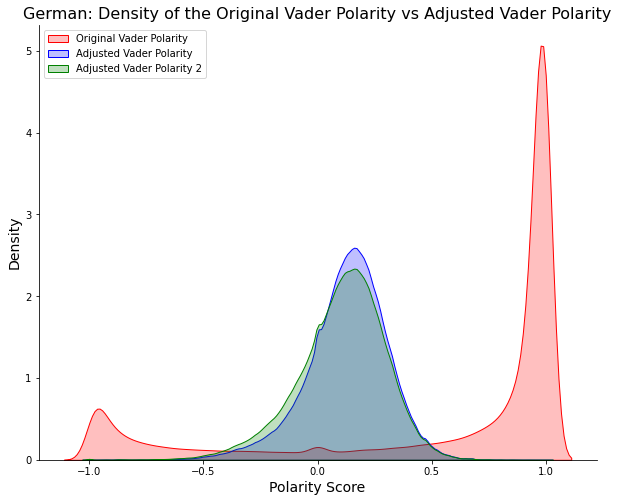

In [13]:
# Compare the density plots of the original and adjusted Vader polarity scores
fig = plt.figure(figsize = (10,8))
ax = sns.kdeplot(Vader_tx_pol.Vader_polarity.values, shade = True, color = 'red', label = "Original Vader Polarity")
ax = sns.kdeplot(Vader_tx_pol.Vader_polarity_adj.values, shade = True, color = 'blue', label = "Adjusted Vader Polarity")
ax = sns.kdeplot(Vader_tx_pol.Vader_polarity_adj_2.values, shade = True, color = 'green', label = "Adjusted Vader Polarity 2")
ax.set_title("German: Density of the Original Vader Polarity vs Adjusted Vader Polarity")
ax.set_xlabel("Polarity Score")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc = 'upper left')
plt.show()

In [14]:
# Save the results to a csv file
Vader_tx_pol.to_csv("Sentiment/Vader/GerVADER/de_vader_polarity_combined.csv", index = True, encoding = 'utf-8-sig')